Epigenetic Reader Protein Binding  
============================

Self-consistent field theory for multiple marks
------------------------------------------------------

In [4]:
import sys
sys.path.insert(1, './wlcstat/')
import numpy as np
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [155]:
def eval_f_bind(n_b, n_m, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        Number of reader proteins bound to the nucleosome
    n_m : integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind = 0

    if n_b == 0:
        f_bind = 0
    elif n_b == 1:
        if n_m == 0:
            f_bind = -np.log(2)
        elif n_m == 1:
            f_bind = -np.log(1. + np.exp(-e_m))
        elif n_m == 2:
            f_bind = e_m - np.log(2)
    elif n_b == 2:
        if n_m == 0:
            f_bind = j_int
        elif n_m == 1:
            f_bind = e_m + j_int
        elif n_m == 2:
            f_bind = 2 * e_m + j_int
    
    return f_bind

def eval_opt_func(x, mu, e_m, v_int, f_om, phi_c):
    r"""
    eval_opt_func - Evaluate the binding state for 
    
    """

    # Convert to average bound variable and phi variable
    n_bind = len(mu) # number of reader protein types
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    phi_bind = np.zeros(n_bind)
    for mark in range(n_bind):
        ind0 = mark * 3 
#         phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 2)] * s_bind[ind0:(ind0 + 2)]) # ORGINAL. OBOE
        phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) # MINE
    erg_int = np.matmul(v_int, phi_bind)
    
    # Evaluate the optimization function
    opt_func = np.zeros(n_bind * 3)
    
    ind = 0
    for mark in range(n_bind): # for each reader protein/ mark type
        for om in range(3): # for each possible number of marked tails on nucl
            f_bind_1 = eval_f_bind(1, om, e_m[mark], v_int[mark, mark])
            f_bind_2 = eval_f_bind(2, om, e_m[mark], v_int[mark, mark])
            q = 1 + np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])
            #calculate the difference b/w new and previous avg binding state 
            # FOR opt.fsolve:
            opt_func[ind] = s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
                                             2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q        
#             # FOR opt.minimize
#             opt_func[ind] = (s_bind[ind] - (np.exp(mu[mark] - f_bind_1 - erg_int[mark]) + 
#                                              2 * np.exp(2 * mu[mark] - f_bind_2 - 2 * erg_int[mark])) / q)**2                     
    
            ind += 1
    
    return opt_func

def eval_s_bind(mu, e_m, v_int, f_om, phi_c, x0, mu_fail_arr):
    # Convert to average bound variable and phi variable
    n_bind = len(mu)
    for mark in range(n_bind):
        ind0 = mark * 3
#         indf = ind0 + 2 # ORGINAL OBOE
        indf = ind0 + 3 # MINE
        f_om[ind0:indf] /= np.sum(f_om[ind0:indf])
    
    x = np.zeros(n_bind * 3)
    
    data = [mu, e_m, v_int, f_om, phi_c]

    #doing unbounded non-linear solver for x, then calc (bounded) var s_bind
    x = opt.root(eval_opt_func, x0=x0, args=tuple(data))
#
    suc = x.success
    msg = x.message
    x = x.x
    
    test = eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)
    if  not suc:
        
#         print("failure at mu = ", str(mu))
#         print("test: ", test)
#         print("suc: ", suc)
#         print(msg)
#         print("------------------")
        
        mu_fail_arr= np.append(mu, mu_fail_arr)
        return [np.nan]*n_bind*3, mu_fail_arr
    
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    return s_bind, mu_fail_arr

## Langmuir isotherm analysis single protein

In [129]:
n_bind = 1 #types of proteins/marks

e_m = np.array([-1.5]) #binding energy
# e_m = np.array([-8.5]) #binding energy
# e_m = np.array([0]) #binding energy
f_om = np.array([1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
# v_int = np.array([[-3.92]]) # protein-protein interaction param
# v_int = np.array([[-1.8]]) # protein-protein interaction param
v_int = np.array([[-8]])
phi_c = 0.6# avg amount of chromosome 

x = np.zeros(n_bind * 3)

In [130]:
# MULTIPLE STARTING CONDITIONS, UNBOUNDED
 
mu_array = np.arange(-10, 10, .1)
# mu_array = np.arange(-8, -3, 1)
mul = len(mu_array)
ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4

x0_arr = np.array([ones * x0_min, ones * x0_mid, ones*x0_mid, ones * x0_max])

mu_mid = -5.25
# mu_mid = -9


mu_arrs = [mu_array, mu_array[np.where(mu_array >= mu_mid)], \
           mu_array[np.where(mu_array <= mu_mid)][::-1], mu_array[::-1]]

mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)
f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)

for j,x0 in enumerate(x0_arr):
    mu_ar = mu_arrs[j]
#     print(j)
#     print("mu arr [0]: ", mu_ar[0])
#     print("x0[0] = ", x0[0])
    f_bar_arr = np.zeros(len(mu_ar))
    s_bind_0sig = np.zeros(len(mu_ar))
    s_bind_1sig = np.zeros(len(mu_ar))
    s_bind_2sig = np.zeros(len(mu_ar)) 
    mu_fail_arr = np.array([])
    x00 = x0
    for i,mu in enumerate(mu_ar):
        s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
        f_bar = np.sum(f_om * s_bind)
        s_bind_0sig[i] = s_bind[0]
        s_bind_1sig[i] = s_bind[1]
        s_bind_2sig[i] = s_bind[2]
        f_bar_arr[i] = f_bar
        if s_bind[0] is not np.nan:
            x00 = -np.log( (2/s_bind) - 1)
   
    f_bar_arr_arr[j] = f_bar_arr
    mu_fail_arr_arr[j] = mu_fail_arr
#     print("xxxxxxxxxx end of one iter xxxx")

C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\2984163182.py:42: RuntimeWarning: divide by zero encountered in divide
  x00 = -np.log( (2/s_bind) - 1)


In [128]:
# # MULTIPLE STARTING CONDITIONS, UNBOUNDED
# # adaptive mu_mid
 
# mu_array = np.arange(-10, 10, .1)
# # mu_array = np.arange(-8, -3, 1)
# mul = len(mu_array)
# ones = np.ones(n_bind * 3)
# x0_min = -4
# x0_mid = 0
# x0_max = 4

# x0_arr = np.array([ones*x0_min, ones*x0_max, ones*x0_mid, ones*x0_mid])

# # mu_mid = -5.25
# # mu_mid = -9


# mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)
# f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)

# ####
# mu_arrs_full = [mu_array, mu_array[::-1]]
# x0_arr_full = np.array([ones * x0_min, ones * x0_max])




# for j,x0 in enumerate(x0_arr_full):
#     mu_ar = mu_arrs_full[j]
# #     print(j)
# #     print("mu arr [0]: ", mu_ar[0])
# #     print("x0[0] = ", x0[0])
#     f_bar_arr = np.zeros(len(mu_ar))
#     s_bind_0sig = np.zeros(len(mu_ar))
#     s_bind_1sig = np.zeros(len(mu_ar))
#     s_bind_2sig = np.zeros(len(mu_ar)) 
#     mu_fail_arr = np.array([])
#     x00 = x0
#     for i,mu in enumerate(mu_ar):
#         s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#         f_bar = np.sum(f_om * s_bind)
#         s_bind_0sig[i] = s_bind[0]
#         s_bind_1sig[i] = s_bind[1]
#         s_bind_2sig[i] = s_bind[2]
#         f_bar_arr[i] = f_bar
#         if s_bind[0] is not np.nan:
#             x00 = -np.log( (2/s_bind) - 1)
   
#     f_bar_arr_arr[j] = f_bar_arr
#     mu_fail_arr_arr[j] = mu_fail_arr
# #     print("xxxxxxxxxx end of one iter xxxx")

# f_bar_scan1 = f_bar_arr_arr[0]
# f_bar_scan1 = f_bar_scan1[~np.isnan(f_bar_scan1)]
# f_bar_scan2 = f_bar_arr_arr[1]
# f_bar_scan2 = f_bar_scan2[~np.isnan(f_bar_scan2)]

# diff1 = np.abs(np.diff(f_bar_scan1))
# diff2 = np.abs(np.diff(f_bar_scan2))
# mu_jump1 = np.where(diff1==np.max(diff1))[0][0]
# mu_jump2 = np.where(diff2==np.max(diff2))[0][0]

# mu_mid = (mu_arrs_full[0][mu_jump1] + mu_arrs_full[1][mu_jump2]) / 2


# mu_arrs_mid = [mu_array[np.where(mu_array >= mu_mid)], \
#            mu_array[np.where(mu_array <= mu_mid)][::-1]]
# x0_arr_mid = np.array([ones * x0_mid, ones*x0_mid])

# mu_arrs = [mu_array, mu_array[::-1], mu_array[np.where(mu_array >= mu_mid)], \
#            mu_array[np.where(mu_array <= mu_mid)][::-1]]

# for j,x0 in enumerate(x0_arr_mid):
#     mu_ar = mu_arrs_mid[j]
# #     print(j)
# #     print("mu arr [0]: ", mu_ar[0])
# #     print("x0[0] = ", x0[0])
#     f_bar_arr = np.zeros(len(mu_ar))
#     s_bind_0sig = np.zeros(len(mu_ar))
#     s_bind_1sig = np.zeros(len(mu_ar))
#     s_bind_2sig = np.zeros(len(mu_ar)) 
#     mu_fail_arr = np.array([])
#     x00 = x0
#     for i,mu in enumerate(mu_ar):
#         s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#         f_bar = np.sum(f_om * s_bind)
#         s_bind_0sig[i] = s_bind[0]
#         s_bind_1sig[i] = s_bind[1]
#         s_bind_2sig[i] = s_bind[2]
#         f_bar_arr[i] = f_bar
#         if s_bind[0] is not np.nan:
#             x00 = -np.log( (2/s_bind) - 1)
   
#     f_bar_arr_arr[j+2] = f_bar_arr
#     mu_fail_arr_arr[j+2] = mu_fail_arr
# #     print("xxxxxxxxxx end of one iter xxxx")

# # mum = [0,1,2,3,4,5]
# # ss1 = [0, 0.5, 1, 30, 40]  
# # ss2 = [0, 0.5, 20, 25, 30]
# # mum_mid_1 = np.where(np.diff(ss1)==np.max(np.diff(ss1)))
# # mum_mid_2 = np.where(np.diff(ss2)==np.max(np.diff(ss2)))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

<Figure size 640x480 with 0 Axes>

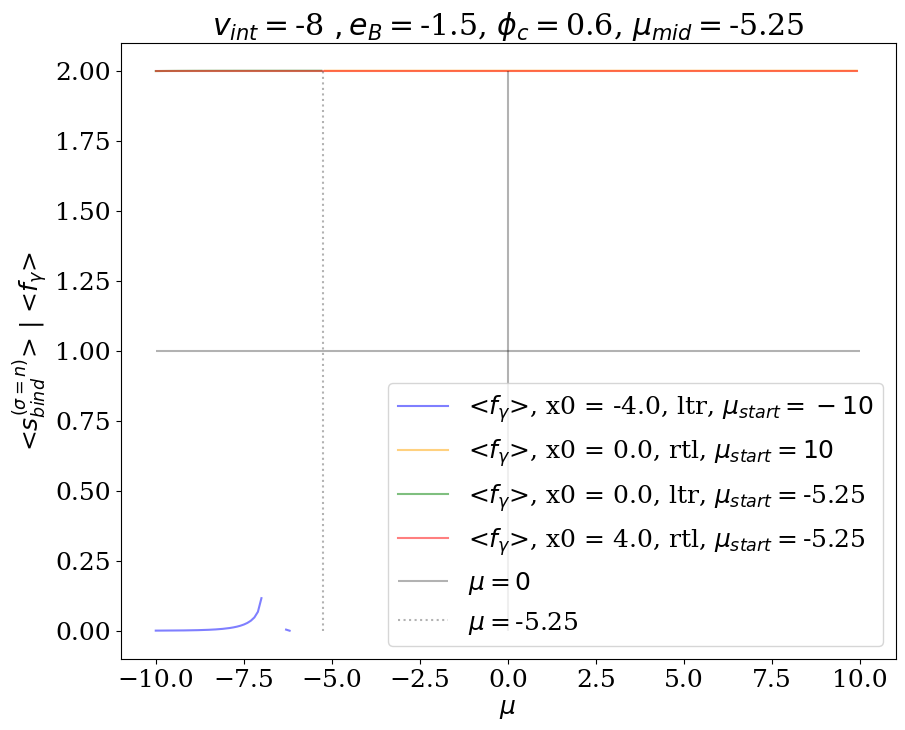

In [131]:
#for adaptive mu_mid
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
# lins = ["-", ":", "-.", "--"]
# lins_bnd = [":", "-", "--", "-."]
lins = ["-"]*6

colors = ["blue","orange","green","red", "pink", "purple"]
for j,x0 in enumerate(x0_arr[:]):
    if j == 0 or j ==2:
        msg = ", ltr"
    else:
        msg = ", rtl"
    if j == 2 or j == 3:
        msg2 = ", $\mu_{start} = $"+ str(np.round(mu_mid,3))
    elif j ==0:
        msg2 =  ", $\mu_{start} = -10$"
    elif j ==1:
         msg2 = ", $\mu_{start} = 10$"
            
#     if x0[0] > -2 and x0[0] < 2:
#     if j ==1:
    plt.plot(mu_arrs[j], f_bar_arr_arr[j], label = "<$ f_{\gamma} $>, x0 = " + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
#         plt.vlines(mu_fail_arr_arr[j], 0,2,color = colors[j])


plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu$")
plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c) +", $\mu_{mid} = $" + str(np.round(mu_mid,3)))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.vlines(mu_mid, 0,2, color = "black", alpha = 0.3, label = "$\mu = $" + str(np.round(mu_mid,3)), linestyle = ":")
plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

In [10]:
# #for non-adaptive mu_mid
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)
# # lins = ["-", ":", "-.", "--"]
# # lins_bnd = [":", "-", "--", "-."]
# lins = ["-"]*6

# colors = ["blue","orange","green","red", "pink", "purple"]
# for j,x0 in enumerate(x0_arr[:]):
#     if j <= 1:
#         msg = ", ltr"
#     else:
#         msg = ", rtl"
#     if j == 1 or j == 2:
#         msg2 = ", $\mu_{start} = $"+ str(np.round(mu_mid,3))
#     elif j ==0:
#         msg2 =  ", $\mu_{start} = -10$"
#     elif j ==3:
#          msg2 = ", $\mu_{start} = 10$"
            
# #     if x0[0] > -2 and x0[0] < 2:
# #     if j ==3 or j == 3 :
#     plt.plot(mu_arrs[j], f_bar_arr_arr[j], label = "<$ f_{\gamma} $>, x0 = " + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
#     plt.vlines(mu_fail_arr_arr[j], 0,2,color = colors[j])


# plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel("$\mu$")
# plt.title("$v_{int} = $" + str(v_int[0][0]) +  " $,e_B = $" + str(e_m[0]) + ", $\phi_c = $" + str(phi_c) +", $\mu_{mid} = $" + str(np.round(mu_mid,3)))
# plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# # plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
# plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
# plt.vlines(mu_mid, 0,2, color = "black", alpha = 0.3, label = "$\mu = $" + str(np.round(mu_mid,3)), linestyle = ":")
# plt.legend()

# # why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
# #check solver- intial conditions? 

## Langmuir isotherm analysis two proteins

In [195]:
n_bind = 2 #types of proteins/marks

e_m = np.array([-1.5, -1.5]) #binding energy
# e_m = np.array([0,-1.5]) #binding energy
f_om = np.array([1/3, 1/3, 1/3, 1/3, 1/3, 1/3]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92, 3.0],[3.0, -3.92]])
# v_int = np.array([[-1,1],[1,-1]]) # protein-protein interaction param
# v_int = np.array([[0,0],[0,0]]) # protein-protein interaction param
phi_c = 1# avg amount of chromosome 

x = np.zeros(n_bind * 3)

# eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

In [200]:
%%time
mu1_array = np.arange(-10, 10, .1)
# mu2_array = [0,10,-10]#np.arange(-10, 10, .1)
mu2_array = [0,10,-5]

mul = len(mu1_array)

ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4
x0_arr = np.array([ones * x0_min])#, ones * x0_mid, ones*x0_mid, ones * x0_max])

mu_mid = -5.25


mu_arrs = [mu1_array]#, mu1_array[np.where(mu1_array >= mu_mid)], \
#            mu1_array[np.where(mu1_array <= mu_mid)][::-1], mu1_array[::-1]]

f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)
# f_bar1_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar2_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar_arrs = [f_bar1_arr, f_bar2_arr]

# s_bind1_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_2sig = np.zeros((len(mu1_array), len(mu2_array)))

# s_bind2_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_2sig = np.zeros((len(mu1_array), len(mu2_array)))

for k,x0 in enumerate(x0_arr):
    mu_ar = mu_arrs[k]
    f_bar1_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar2_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar_arrs = np.array([f_bar1_arr, f_bar2_arr])
#     x00 = x0
#     if k == 0:
#         print(x00)
#     for i, mu1 in enumerate(mu_ar):
#         for j, mu2 in enumerate(mu2_array): # ORIG

    for j, mu2 in enumerate(mu2_array):
        x00 = x0
        for i, mu1 in enumerate(mu_ar):
#             print(x00)
            s_bind, useless_arr = eval_s_bind([mu1, mu2], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#             if k == 0:
#                 print()
#                 print("S_bind: ", s_bind)
#                 print("mu_2: ", mu2)
#                 print("mu_1:", mu1)
#                 print(x00)

            for mark in range(n_bind):
                f_bar_array = f_bar_arrs[mark]
                ind0 = mark * 3
                f_bar_array[i,j] = np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)])
                f_bar_arrs[mark] = f_bar_array
                
            #set previous s_bind as starting point for next s_bind
            if s_bind[0] is not np.nan:
                x00 = -np.log( (2/s_bind) - 1)

#             s_bind1_0sig[i,j] = s_bind[0]
#             s_bind1_1sig[i,j] = s_bind[1]
#             s_bind1_2sig[i,j] = s_bind[2]

#             s_bind2_0sig[i,j] = s_bind[3]
#             s_bind2_1sig[i,j] = s_bind[4]
#             s_bind2_2sig[i,j] = s_bind[5]
    f_bar_arr_arr[k] = f_bar_arrs
    print("onefourth done")
#     f_bar1_arr = f_bar_arrs[0]
#     f_bar2_arr = f_bar_arrs[1]

<timed exec>:63: RuntimeWarning: divide by zero encountered in log
C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\3513860877.py:50: RuntimeWarning: invalid value encountered in divide
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))


onefourth done
CPU times: total: 1min 27s
Wall time: 1min 51s


<Figure size 640x480 with 0 Axes>

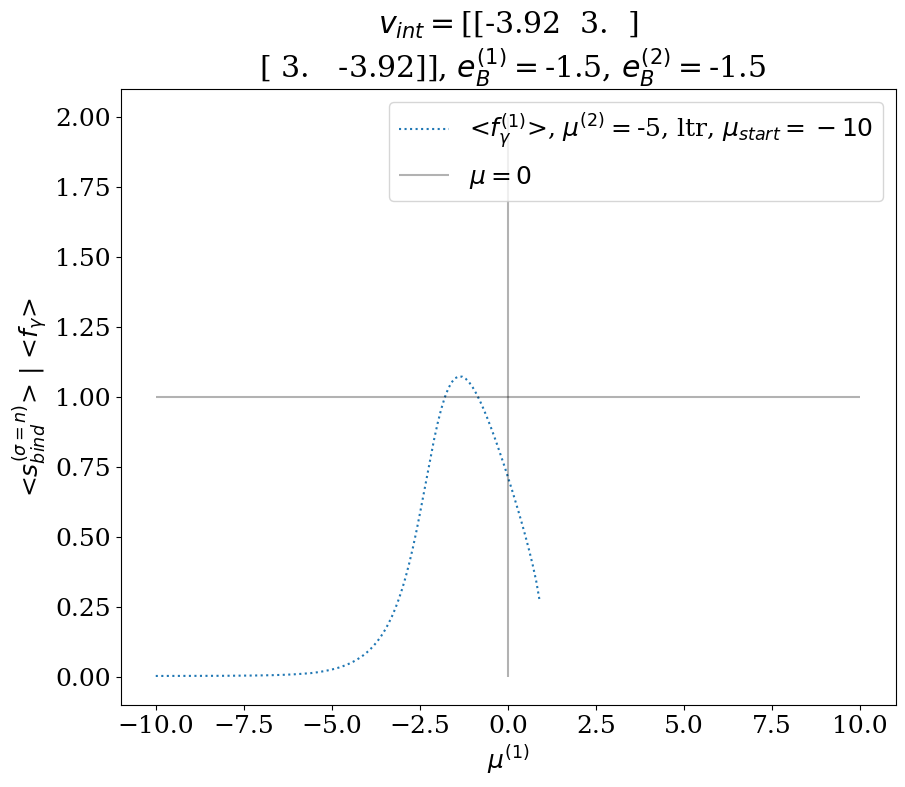

In [201]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

lins = ["-", ":", "-.", "--"]
# lins_bnd = [":", "-", "--", "-."]
# lins = ["-"]*6

colors = ["blue","orange","green","red", "pink", "purple"]
for k,x0 in enumerate(x0_arr[:]):

    if k <= 1:
        msg = ", ltr"
    else:
        msg = ", rtl"
    if k == 1 or k == 2:
        msg2 = ", $\mu_{start} = $"+ str(np.round(mu_mid,3))
    elif k == 0:
        msg2 =  ", $\mu_{start} = -10$"
    elif k ==3:
         msg2 = ", $\mu_{start} = 10$"
    if k ==0:
#         plt.plot(mu_arrs[k], f_bar_arr_arr[k][0][:,0], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = $" + str(mu2_array[0])+ msg +msg2, linestyle = lins[k])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
#         plt.plot(mu_arrs[k], f_bar_arr_arr[k][0][:,1], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = $"+ str(mu2_array[1])+ msg +msg2,linestyle = lins[2])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
        plt.plot(mu_arrs[k], f_bar_arr_arr[k][0][:,2], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = $" +str(mu2_array[2]) + msg +msg2,linestyle = lins[1])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
    
    
# plt.plot(mu1_array, f_bar1_arr[:,0], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 0$", color = "blue")
# # plt.xlabel("$\mu$")
# # plt.ylabel("<$ f_{\gamma} $>")

# plt.plot(mu1_array, f_bar1_arr[:,1], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 10$", color = "green", linestyle = "-.")

# plt.plot(mu1_array, f_bar1_arr[:,2], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = -10$", color = "red", linestyle = "--", zorder = 4)

# # plt.plot(mu1_array, f_bar_arr, label = "<$ f_{\gamma}^{(1)} $> single protein", color = "black")

# # LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
# K = np.exp(-e_m[0])
# plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir", linestyle = ":", color = "black")

# K = np.exp(-0)  # sigma = 0 - all binding energies are 0
# plt.plot(mu_array, 2*K*np.exp(mu_array) / (1+ K*np.exp(mu_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")

# plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel("$\mu$")

plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu^{(1)}$")
plt.title("$v_{int} = $" + str(v_int) +  ", $e_B^{(1)} = $" + str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

### fix ltr mu_start = -10 scan. COMPARE LM to HYBR

In [218]:
def eval_s_bind(mu, e_m, v_int, f_om, phi_c, x0, mu_fail_arr):
    # Convert to average bound variable and phi variable
    n_bind = len(mu)
    for mark in range(n_bind):
        ind0 = mark * 3
#         indf = ind0 + 2 # ORGINAL OBOE
        indf = ind0 + 3 # MINE
        f_om[ind0:indf] /= np.sum(f_om[ind0:indf])
    
    x = np.zeros(n_bind * 3)
    
    data = [mu, e_m, v_int, f_om, phi_c]

    #doing unbounded non-linear solver for x, then calc (bounded) var s_bind
    x = opt.root(eval_opt_func, x0=x0, args=tuple(data),method="lm")# options={"maxfev":int(1e6)})
#
    suc = x.success
    msg = x.message
    x = x.x
    
    test = eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)
    if not suc:
        
#         print("failure at mu = ", str(mu))
#         print("test: ", test)
#         print("suc: ", suc)
#         print(msg)
#         print("------------------")
        
        mu_fail_arr= np.append(mu, mu_fail_arr)
        return [np.nan]*n_bind*3, mu_fail_arr
    
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    return s_bind, mu_fail_arr

In [203]:
%%time
mu1_array_lm = np.arange(-10, 10, .25)
# mu2_array = [0,10,-10]#np.arange(-10, 10, .1)
mu2_array = [0,10,-5]

mul = len(mu1_array_lm)

ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4
x0_arr = np.array([ones * x0_min])#, ones * x0_mid, ones*x0_mid, ones * x0_max])

mu_mid = -5.25


mu_arrs = [mu1_array_lm]#, mu1_array[np.where(mu1_array >= mu_mid)], \
#            mu1_array[np.where(mu1_array <= mu_mid)][::-1], mu1_array[::-1]]

f_bar_arr_arr_lm = np.zeros(len(x0_arr), dtype = object)
# f_bar1_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar2_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar_arrs = [f_bar1_arr, f_bar2_arr]

# s_bind1_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_2sig = np.zeros((len(mu1_array), len(mu2_array)))

# s_bind2_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_2sig = np.zeros((len(mu1_array), len(mu2_array)))

for k,x0 in enumerate(x0_arr):
    mu_ar = mu_arrs[k]
    f_bar1_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar2_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar_arrs = np.array([f_bar1_arr, f_bar2_arr])
#     x00 = x0
#     if k == 0:
#         print(x00)
#     for i, mu1 in enumerate(mu_ar):
#         for j, mu2 in enumerate(mu2_array): # ORIG

    for j, mu2 in enumerate(mu2_array):
        x00 = x0
        for i, mu1 in enumerate(mu_ar):
#             print(x00)
            s_bind, useless_arr = eval_s_bind([mu1, mu2], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#             if k == 0:
#                 print()
#                 print("S_bind: ", s_bind)
#                 print("mu_2: ", mu2)
#                 print("mu_1:", mu1)
#                 print(x00)

            for mark in range(n_bind):
                f_bar_array = f_bar_arrs[mark]
                ind0 = mark * 3
                f_bar_array[i,j] = np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)])
                f_bar_arrs[mark] = f_bar_array
                
            #set previous s_bind as starting point for next s_bind
            if s_bind[0] is not np.nan:
                x00 = -np.log( (2/s_bind) - 1)

#             s_bind1_0sig[i,j] = s_bind[0]
#             s_bind1_1sig[i,j] = s_bind[1]
#             s_bind1_2sig[i,j] = s_bind[2]

#             s_bind2_0sig[i,j] = s_bind[3]
#             s_bind2_1sig[i,j] = s_bind[4]
#             s_bind2_2sig[i,j] = s_bind[5]
    f_bar_arr_arr_lm[k] = f_bar_arrs
    print("onefourth done")
#     f_bar1_arr = f_bar_arrs[0]
#     f_bar2_arr = f_bar_arrs[1]

<timed exec>:63: RuntimeWarning: divide by zero encountered in log
C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\3513860877.py:50: RuntimeWarning: invalid value encountered in divide
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))


onefourth done
CPU times: total: 34.5 s
Wall time: 41.4 s


In [204]:
def eval_s_bind(mu, e_m, v_int, f_om, phi_c, x0, mu_fail_arr):
    # Convert to average bound variable and phi variable
    n_bind = len(mu)
    for mark in range(n_bind):
        ind0 = mark * 3
#         indf = ind0 + 2 # ORGINAL OBOE
        indf = ind0 + 3 # MINE
        f_om[ind0:indf] /= np.sum(f_om[ind0:indf])
    
    x = np.zeros(n_bind * 3)
    
    data = [mu, e_m, v_int, f_om, phi_c]

    #doing unbounded non-linear solver for x, then calc (bounded) var s_bind
    x = opt.root(eval_opt_func, x0=x0, args=tuple(data),method="hybr")# options={"maxfev":int(1e6)})
#
    suc = x.success
    msg = x.message
    x = x.x
    
    test = eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)
    if  not suc:
        
#         print("failure at mu = ", str(mu))
#         print("test: ", test)
#         print("suc: ", suc)
#         print(msg)
#         print("------------------")
        
        mu_fail_arr= np.append(mu, mu_fail_arr)
        return [np.nan]*n_bind*3, mu_fail_arr
    
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    return s_bind, mu_fail_arr

In [205]:
%%time
mu1_array = np.arange(-10, 10, 0.1)
# mu2_array = [0,10,-10]#np.arange(-10, 10, .1)
mu2_array = [0,10,-5]

mul = len(mu1_array)

ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4
x0_arr = np.array([ones * x0_min])#, ones * x0_mid, ones*x0_mid, ones * x0_max])

mu_mid = -5.25


mu_arrs = [mu1_array]#, mu1_array[np.where(mu1_array >= mu_mid)], \
#            mu1_array[np.where(mu1_array <= mu_mid)][::-1], mu1_array[::-1]]

f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)
# f_bar1_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar2_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar_arrs = [f_bar1_arr, f_bar2_arr]

# s_bind1_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_2sig = np.zeros((len(mu1_array), len(mu2_array)))

# s_bind2_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_2sig = np.zeros((len(mu1_array), len(mu2_array)))

for k,x0 in enumerate(x0_arr):
    mu_ar = mu_arrs[k]
    f_bar1_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar2_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar_arrs = np.array([f_bar1_arr, f_bar2_arr])
#     x00 = x0
#     if k == 0:
#         print(x00)
#     for i, mu1 in enumerate(mu_ar):
#         for j, mu2 in enumerate(mu2_array): # ORIG

    for j, mu2 in enumerate(mu2_array):
        x00 = x0
        for i, mu1 in enumerate(mu_ar):
#             print(x00)
            s_bind, useless_arr = eval_s_bind([mu1, mu2], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#             if k == 0:
#                 print()
#                 print("S_bind: ", s_bind)
#                 print("mu_2: ", mu2)
#                 print("mu_1:", mu1)
#                 print(x00)

            for mark in range(n_bind):
                f_bar_array = f_bar_arrs[mark]
                ind0 = mark * 3
                f_bar_array[i,j] = np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)])
                f_bar_arrs[mark] = f_bar_array
                
            #set previous s_bind as starting point for next s_bind
            if s_bind[0] is not np.nan:
                x00 = -np.log( (2/s_bind) - 1)

#             s_bind1_0sig[i,j] = s_bind[0]
#             s_bind1_1sig[i,j] = s_bind[1]
#             s_bind1_2sig[i,j] = s_bind[2]

#             s_bind2_0sig[i,j] = s_bind[3]
#             s_bind2_1sig[i,j] = s_bind[4]
#             s_bind2_2sig[i,j] = s_bind[5]
    f_bar_arr_arr[k] = f_bar_arrs
    print("onefourth done")
#     f_bar1_arr = f_bar_arrs[0]
#     f_bar2_arr = f_bar_arrs[1]

C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\3513860877.py:50: RuntimeWarning: overflow encountered in exp
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\3513860877.py:50: RuntimeWarning: invalid value encountered in divide
  s_bind = 2. * np.exp(x) / (1 + np.exp(x))


onefourth done
CPU times: total: 2.23 s
Wall time: 2.79 s


<Figure size 640x480 with 0 Axes>

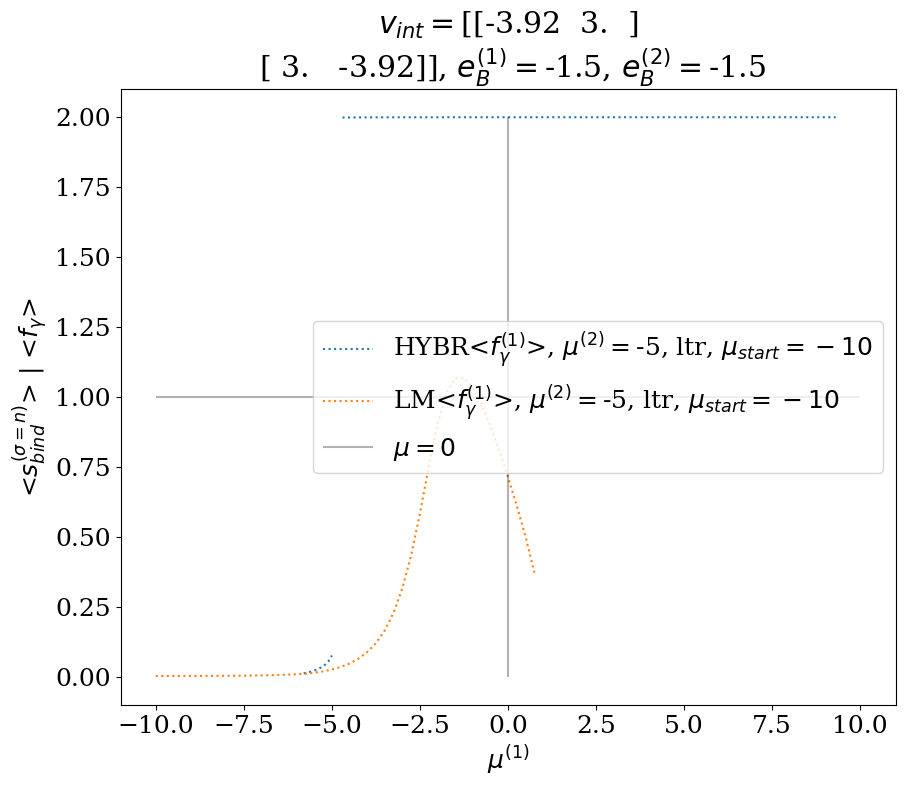

In [207]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

lins = ["-", ":", "-.", "--"]
# lins_bnd = [":", "-", "--", "-."]
# lins = ["-"]*6

colors = ["blue","orange","green","red", "pink", "purple"]
for k,x0 in enumerate(x0_arr[:]):

    if k <= 1:
        msg = ", ltr"
    else:
        msg = ", rtl"
    if k == 1 or k == 2:
        msg2 = ", $\mu_{start} = $"+ str(np.round(mu_mid,3))
    elif k == 0:
        msg2 =  ", $\mu_{start} = -10$"
    elif k ==3:
         msg2 = ", $\mu_{start} = 10$"
    if k ==0:
#         plt.plot(mu_arrs[k], f_bar_arr_arr[k][0][:,0], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = $" + str(mu2_array[0])+ msg +msg2, linestyle = lins[k])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
#         plt.plot(mu_arrs[k], f_bar_arr_arr[k][0][:,1], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = $"+ str(mu2_array[1])+ msg +msg2,linestyle = lins[2])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
        plt.plot(mu1_array, f_bar_arr_arr[k][0][:,2], label = "HYBR<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = $" +str(mu2_array[2]) + msg +msg2,linestyle = lins[1])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
        plt.plot(mu1_array_lm, f_bar_arr_arr_lm[k][0][:,2], label = "LM<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = $" +str(mu2_array[2]) + msg +msg2,linestyle = lins[1])# + str(x0[0]) + msg +msg2, linestyle = lins[j], alpha = 0.5, color = colors[j])
    
    
# plt.plot(mu1_array, f_bar1_arr[:,0], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 0$", color = "blue")
# # plt.xlabel("$\mu$")
# # plt.ylabel("<$ f_{\gamma} $>")

# plt.plot(mu1_array, f_bar1_arr[:,1], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = 10$", color = "green", linestyle = "-.")

# plt.plot(mu1_array, f_bar1_arr[:,2], label = "<$ f_{\gamma}^{(1)} $>, $\mu^{(2)} = -10$", color = "red", linestyle = "--", zorder = 4)

# # plt.plot(mu1_array, f_bar_arr, label = "<$ f_{\gamma}^{(1)} $> single protein", color = "black")

# # LANGMUIR. Assumptions only valid when v_int = 0, and for sigma =0 or 2 (all sites identical)
# K = np.exp(-e_m[0])
# plt.plot(mu1_array, 2*K*np.exp(mu1_array) / (1+ K*np.exp(mu1_array)), label = "langmuir", linestyle = ":", color = "black")

# K = np.exp(-0)  # sigma = 0 - all binding energies are 0
# plt.plot(mu_array, 2*K*np.exp(mu_array) / (1+ K*np.exp(mu_array)), label = "langmuir, e_b = 0", linestyle = "-.", color = "black")

# plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
# plt.xlabel("$\mu$")

plt.ylabel("<$ s_{bind}^{(\sigma = n)}$> | <$ f_{\gamma} $>")
plt.xlabel("$\mu^{(1)}$")
plt.title("$v_{int} = $" + str(v_int) +  ", $e_B^{(1)} = $" + str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]))
plt.hlines(1, -10, 10, color = "black", alpha = 0.3)
# plt.vlines(-.75, 0,2, color = "black", alpha = 0.3, label = "$\mu = -0.75$")
plt.vlines(-0, 0,2, color = "black", alpha = 0.3, label = "$\mu = 0$")
plt.legend()

# why is s_bind = 2 * (exp(x \ (1 + exp)))? how did that realtion come about. it is to allow for unbounded minimizationq
#check solver- intial conditions? 

## $\langle s_{i}^{(\gamma_1)} s_{j}^{(\gamma_1')} \rangle$ calculation

In [14]:
def eval_f_bind_vec(n_b, n_m_arr, e_m = -1.5, j_int = -3.92):
    r"""
    eval_f_bind - Evaluate the binding free energy
    
    Parameters
    ----------
    n_b : integer
        array of Number of reader proteins bound to the nucleosome
    n_m_arr : arr of integer
        Number of marked tails
    e_me3 : float
        Favorable binding free energy to tri-methylated tails
        
    Returns
    -------
    f_bind : float
        Binding free energy
    
    """
    # Calculate the cases for the binding free energy
    f_bind_arr = np.zeros(len(n_m_arr))
    for i,n_m in enumerate(n_m_arr):
        f_bind = 0
        if n_b == 0:
            f_bind = 0
        elif n_b == 1:
            if n_m == 0:
                f_bind = -np.log(2)
            elif n_m == 1:
                f_bind = -np.log(1. + np.exp(-e_m))
            elif n_m == 2:
                f_bind = e_m - np.log(2)
        elif n_b == 2:
            if n_m == 0:
                f_bind = j_int
            elif n_m == 1:
                f_bind = e_m + j_int
            elif n_m == 2:
                f_bind = 2 * e_m + j_int
        f_bind_arr[i] = f_bind
    return f_bind_arr

# need to produce rank 2 tensor that, given two protein types, 
# find avg of product of s for index ij
def eval_sisj_bind(s_bind, mu, e_m, v_int, f_om, phi_c, poly_marks, gam1_ind, gam2_ind):
    '''
    poly marks (array of arrays) contains an array of marks per nucleosome for each protein type
    gam1_ind (int) is the index of first protein
    gam2_ind (int) is the index of second protein
    '''
    
    n_bind = len(mu)
    # evaluate eqn 85 for each index ij
 
    phi_bind = np.zeros(n_bind) #phi_c times f_gamma
    for mark in range(n_bind):
        ind0 = mark * 3             # VVV calc of bar{f}_\gamma (eqn 86) VVV
        phi_bind[mark] = phi_c * np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) 
    erg_int = np.matmul(v_int, phi_bind) #sum over gamma 2 of int and phi and f
    
    coef1 = erg_int[gam1_ind] + mu[gam1_ind] 
    coef2 = erg_int[gam2_ind] + mu[gam2_ind]
    
    #make vector form of f_bind
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[gam2_ind], e_m[gam2_ind])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[gam2_ind], e_m[gam2_ind])
    
    #combine coef and f_bind to create 4 dif energies needed
#     - each should be rank 2 tensors
    
    exp_g1_s1 = np.exp(coef1 + f_bind_g1_s1)
    exp_g1_s2 = np.exp(2*coef1 + f_bind_g1_s2)
    exp_g2_s1 = np.exp(coef2 + f_bind_g2_s1)
    exp_g2_s2 = np.exp(2*coef2 + f_bind_g2_s2)
    
    exp_11 = np.outer(exp_g1_s1, exp_g2_s1)
    exp_12 = np.outer(exp_g1_s1, exp_g2_s2)
    exp_21 = np.outer(exp_g1_s2, exp_g2_s1)
    exp_22 = np.outer(exp_g1_s2, exp_g2_s2)
    
#     # calc q_0 (all probabilities)
    q = 1 + np.outer(exp_g1_s1, exp_g1_s1) + np.outer(exp_g2_s1, exp_g2_s1)\
    + np.outer(exp_g1_s2, exp_g1_s2) + np.outer(exp_g2_s2, exp_g2_s2)\
    + exp_11 + exp_12 + exp_21 + exp_22
    
    #calculate average matrix (eq 85)
    sisj_bind = (exp_11 + exp_12 + exp_21 + exp_22) / q
    return sisj_bind 

In [15]:
n_bind = 2 #types of proteins/marks

# mu = np.array([-4.5, -5]) #chemical potential in solution
# e_m = np.array([-1.5, -1.5]) #binding energy
# f_om = np.array([0.5, 0, 0.5, 0.75, 0, 0.25]) # fraction of nucleosomes with 0,1,2 marks per protein type
# v_int = np.array([[-3.92, 3.0],[3.0, -3.92]]) # protein-protein interaction param
# phi_c = 0.6 # avg amount of chromosome 

mu = np.array([-4.7, -5]) #chemical potential in solution
e_m = np.array([-1.5, -1.5]) #binding energy
f_om = np.array([0.5, 0, 0.5, 0.75, 0, 0.25]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92, 3.0],[3.0, -3.92]]) # protein-protein interaction param
# v_int = np.array([[0, 0],[0, 0]]) # protein-protein interaction param
phi_c = 0.6 # avg amount of chromosome 

x = np.zeros(n_bind * 3)

marks_1 = [0,2,0,2] # marks for protein 1
marks_2 = [0,0,0,2] # marks for protein 2
poly_marks = [marks_1, marks_2]
eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)

array([0.94565712, 0.8256193 , 0.53609814, 0.96388729, 0.88493213,
       0.6926975 ])

In [16]:
# TODO: need to consider possibiltiy of two solutions- need to compare free energy of higher and lower soln
x00 = [-4]*6
s_bind, uselses_ar = eval_s_bind(mu, e_m, v_int, f_om, phi_c, x00, [])
eval_sisj_bind(s_bind, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)

array([[5.98837550e-06, 1.33600430e-06, 5.98837550e-06, 1.33600430e-06],
       [1.33600430e-06, 2.98058821e-07, 1.33600430e-06, 2.98058821e-07],
       [5.98837550e-06, 1.33600430e-06, 5.98837550e-06, 1.33600430e-06],
       [1.33600430e-06, 2.98058821e-07, 1.33600430e-06, 2.98058821e-07]])

## Determine the effective $\chi$-parameter matrix (andy)

In [17]:
# TODO: make so that this fiunction takes s_bind as an input (from s_bind curve)
def eval_chi_mat(mu, e_m, v_int, f_om, phi_c):
    n_bind = len(mu)
    chi_mat = np.zeros((3 * n_bind, 3 * n_bind))
    
    x00 = [-4]*n_bind*3
    s_bind, usles_ar = eval_s_bind(mu, e_m, v_int, f_om, phi_c, x00, [])
    
    for m1 in range(n_bind):
        for s1 in range(3):
            i1 = m1 * 3 + s1
            for m2 in range(n_bind):
                for s2 in range(3):
                    i2 = m2 * 3 + s2
#                     print("sbind: ", s_bind)
#                     print(s_bind[i1])
#                     print(v_int[m1, m2])
#                     print(s_bind[i2])
                    e12 = 0.5 * s_bind[i1] * v_int[m1, m2] * s_bind[i2]
                    e11 = 0.5 * s_bind[i1] * v_int[m1, m1] * s_bind[i1]
                    e22 = 0.5 * s_bind[i2] * v_int[m2, m2] * s_bind[i2]
                    chi_mat[i1, i2] = e12 - 0.5 * (e11 + e22)
    
    return chi_mat

In [18]:
eval_chi_mat(mu, e_m, v_int, f_om, phi_c)

array([[0.        , 0.01705221, 0.19583111, 0.00453122, 0.00722535,
        0.01499364],
       [0.01705221, 0.        , 0.09730903, 0.03907901, 0.04586747,
        0.06170648],
       [0.19583111, 0.09730903, 0.        , 0.25965196, 0.27622108,
        0.31133972],
       [0.00453122, 0.03907901, 0.25965196, 0.        , 0.00041962,
        0.00370439],
       [0.00722535, 0.04586747, 0.27622108, 0.00041962, 0.        ,
        0.00163047],
       [0.01499364, 0.06170648, 0.31133972, 0.00370439, 0.00163047,
        0.        ]])

# test sf2 calc

In [283]:
#edit for chromo
def calc_sf2(poly_marks, N_m, b, M2s, k_vec = np.logspace(-2, 2, 50)):
    M2_AA, M2_AB, M2_BA, M2_BB = M2s
    
    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m
        
    grid = np.indices((M, M))
    j1 = grid[0]
    j2 = grid[1]

    S2_AA_arr = np.zeros(nk)
    S2_AB_arr = np.zeros(nk)
    S2_BA_arr = np.zeros(nk)
    S2_BB_arr = np.zeros(nk)
#     if (not plotting) and (mix.C2 != "empty"):
#         C = mix.C2
#         S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
#         S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
#         S2_BA_arr[i] = np.sum((1/M**2) * C * M2_BA)
#         S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
    for i, k in enumerate(k_vec):
        C = np.zeros((M, M))
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = (j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 
        
        C[np.where((index) != 0)] += debye
        
        #j1 > j2, s1 s2 any
        index = (j1 > j2)
        constant = np.exp(-x_m*(j1-j2))
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
        
        #j2 > j1, s1 s2 any
        index = (j2 > j1)
        constant = np.exp(-x_m*(j2-j1))
#         integral is the same

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral   
#         print(C/M**2)
        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
        S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
        S2_BA_arr[i] = np.sum((1/M**2) * C * M2_BA)
        S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
    return S2_AA_arr*N**2, S2_AB_arr*N**2, S2_BA_arr*N**2, S2_BB_arr*N**2

def eval_s_bind(mu, e_m, v_int, f_om, phi_c, x0, mu_fail_arr):
    # Convert to average bound variable and phi variable
    n_bind = len(mu)
    for mark in range(n_bind):
        ind0 = mark * 3
#         indf = ind0 + 2 # ORGINAL OBOE
        indf = ind0 + 3 # MINE
        f_om[ind0:indf] /= np.sum(f_om[ind0:indf])
    
    x = np.zeros(n_bind * 3)
    
    data = [mu, e_m, v_int, f_om, phi_c]

    #doing unbounded non-linear solver for x, then calc (bounded) var s_bind
    x = opt.root(eval_opt_func, x0=x0, args=tuple(data),method="lm")# options={"maxfev":int(1e6)})
#
    suc = x.success
    msg = x.message
    x = x.x
    
    test = eval_opt_func(x, mu, e_m, v_int, f_om, phi_c)
    if not suc:
        
#         print("failure at mu = ", str(mu))
#         print("test: ", test)
#         print("suc: ", suc)
#         print(msg)
#         print("------------------")
        
        mu_fail_arr= np.append(mu, mu_fail_arr)
        return [np.nan]*n_bind*3, mu_fail_arr
    
    s_bind = 2. * np.exp(x) / (1 + np.exp(x))
    
    return s_bind, mu_fail_arr

def eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, gam1_ind, gam2_ind):
    '''
    poly marks (array of arrays) contains an array of marks per nucleosome for each protein type
    gam1_ind (int) is the index of first protein
    gam2_ind (int) is the index of second protein
    '''
    
    n_bind = len(mu)
    # evaluate eqn 85 for each index ij
 
    phi_bind =phi_c * np.array(f_bars)
#     phi_bind = np.zeros(n_bind) #phi_c times f_gamma
#     for mark in range(n_bind):
#         ind0 = mark * 3             # VVV calc of bar{f}_\gamma (eqn 86) VVV
#         phi_bind[mark] = phi_c * f_bars[mark]#np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)]) 

    erg_int = np.matmul(v_int, phi_bind) #sum over gamma 2 of int and phi and f
    
    coef1 = erg_int[gam1_ind] + mu[gam1_ind] 
    coef2 = erg_int[gam2_ind] + mu[gam2_ind]
    
    #make vector form of f_bind
    f_bind_g1_s1 = eval_f_bind_vec(1, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g1_s2 = eval_f_bind_vec(2, poly_marks[gam1_ind], e_m[gam1_ind])
    f_bind_g2_s1 = eval_f_bind_vec(1, poly_marks[gam2_ind], e_m[gam2_ind])
    f_bind_g2_s2 = eval_f_bind_vec(2, poly_marks[gam2_ind], e_m[gam2_ind])
    
    #combine coef and f_bind to create 4 dif energies needed
#     - each should be rank 2 tensors
    
    exp_g1_s1 = np.exp(coef1 + f_bind_g1_s1)
    exp_g1_s2 = np.exp(2*coef1 + f_bind_g1_s2)
    exp_g2_s1 = np.exp(coef2 + f_bind_g2_s1)
    exp_g2_s2 = np.exp(2*coef2 + f_bind_g2_s2)
    
    exp_11 = np.outer(exp_g1_s1, exp_g2_s1)
    exp_12 = np.outer(exp_g1_s1, exp_g2_s2)
    exp_21 = np.outer(exp_g1_s2, exp_g2_s1)
    exp_22 = np.outer(exp_g1_s2, exp_g2_s2)
    
#     # calc q_0 (all probabilities)
    q = 1 + np.outer(exp_g1_s1, exp_g1_s1) + np.outer(exp_g2_s1, exp_g2_s1)\
    + np.outer(exp_g1_s2, exp_g1_s2) + np.outer(exp_g2_s2, exp_g2_s2)\
    + exp_11 + exp_12 + exp_21 + exp_22
    
    #calculate average matrix (eq 85)
    sisj_bind = (exp_11 + exp_12 + exp_21 + exp_22) / q
    return sisj_bind 

In [284]:
n_bind = 2 #types of proteins/marks

# mu = np.array([-4.5, -5]) #chemical potential in solution
# mu = np.array([-8, -8]) #chemical potential in solution
e_m = np.array([-1.5, -1.5]) #binding energy
f_om = np.array([0.5, 0, 0.5, 0.75, 0, 0.25]) # fraction of nucleosomes with 0,1,2 marks per protein type
v_int = np.array([[-3.92, 3.0],[3.0, -3.92]]) # protein-protein interaction param
# v_int = np.array([[0, 0],[0, 0]]) # protein-protein interaction param
phi_c = 0.6 # avg amount of chromosome 

x = np.zeros(n_bind * 3)

marks_1 = [0,2,0,2] # marks for protein 1
marks_2 = [0,0,0,2] # marks for protein 2
poly_marks = [marks_1, marks_2]

k_vec = np.logspace(-2, 2, 50)

In [285]:
# calculate s_bind ltr mu_Start = -10 scan
# pull from calculated s_binds to calculate s2s
# stBILITY ANALYSIS

In [286]:
#1) calculate s_bind arr 

In [287]:
%%time
mu1_array = np.arange(-9, -3, 1)
# mu2_array = [0,10,-10]#np.arange(-10, 10, .1)
mu2_array = np.arange(-9, -3, 1)

mul = len(mu1_array)

ones = np.ones(n_bind * 3)
x0_min = -4
x0_mid = 0
x0_max = 4
x0_arr = np.array([ones * x0_min])#, ones * x0_mid, ones*x0_mid, ones * x0_max])
# x0_arr = [[-4,-4,-4,-2,-2,-2]]

mu_arrs = [mu1_array]#, mu1_array[np.where(mu1_array >= mu_mid)], \
#            mu1_array[np.where(mu1_array <= mu_mid)][::-1], mu1_array[::-1]]

f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)
# f_bar1_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar2_arr = np.zeros((len(mu1_array), len(mu2_array)))
# f_bar_arrs = [f_bar1_arr, f_bar2_arr]

# s_bind1_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind1_2sig = np.zeros((len(mu1_array), len(mu2_array)))

# s_bind2_0sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_1sig = np.zeros((len(mu1_array), len(mu2_array)))
# s_bind2_2sig = np.zeros((len(mu1_array), len(mu2_array)))

for k,x0 in enumerate(x0_arr):
    mu_ar = mu_arrs[k]
    f_bar1_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar2_arr = np.zeros((len(mu_ar), len(mu2_array)))
    f_bar_arrs = np.array([f_bar1_arr, f_bar2_arr])
#     x00 = x0
#     if k == 0:
#         print(x00)
#     for i, mu1 in enumerate(mu_ar):
#         for j, mu2 in enumerate(mu2_array): # ORIG

    for j, mu2 in enumerate(mu2_array):
        x00 = x0
        for i, mu1 in enumerate(mu_ar):
#             print(x00)
            s_bind, useless_arr = eval_s_bind([mu1, mu2], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#             if s_bind[0] is np.nan:
#                 print("fail")
#             if k == 0:
#                 print()
#                 print("S_bind: ", s_bind)
#                 print("mu_2: ", mu2)
#                 print("mu_1:", mu1)
#                 print(x00)

            for mark in range(n_bind):
                f_bar_array = f_bar_arrs[mark]
                ind0 = mark * 3
                f_bar_array[i,j] = np.sum(f_om[ind0:(ind0 + 3)] * s_bind[ind0:(ind0 + 3)])
                f_bar_arrs[mark] = f_bar_array
                
            #set previous s_bind as starting point for next s_bind
            if s_bind[0] is not np.nan:
                x00 = -np.log( (2/s_bind) - 1)

#             s_bind1_0sig[i,j] = s_bind[0]
#             s_bind1_1sig[i,j] = s_bind[1]
#             s_bind1_2sig[i,j] = s_bind[2]

#             s_bind2_0sig[i,j] = s_bind[3]
#             s_bind2_1sig[i,j] = s_bind[4]
#             s_bind2_2sig[i,j] = s_bind[5]
    f_bar_arr_arr[k] = f_bar_arrs
#     f_bar1_arr = f_bar_arrs[0]
#     f_bar2_arr = f_bar_arrs[1]

f_bar_arrs = f_bar_arr_arr[0]

fail
fail
CPU times: total: 828 ms
Wall time: 1.04 s


In [292]:
# TODO: need to consider possibiltiy of two solutions- need to compare free energy (gen sfs) of higher and lower soln

mu = np.array([-6, -8]) #chemical potential in solution

f_bar_0 = f_bar_arrs[0][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]
f_bar_1 = f_bar_arrs[1][np.where(mu1_array == mu[0]), np.where(mu2_array== mu[1])][0][0]

f_bars = [f_bar_0, f_bar_1]
sisj_AA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 0)
sisj_AB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 0, 1)
sisj_BA = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 0)
sisj_BB = eval_sisj_bind(f_bars, mu, e_m, v_int, f_om, phi_c, poly_marks, 1, 1)
M2s = [sisj_AA,sisj_AB,sisj_BA,sisj_BB]

N_m = 1
b = 1
[S2_AA_arr, S2_AB_arr, S2_BA_arr, S2_BB_arr] = calc_sf2(poly_marks, N_m, b, M2s)

C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\1207733901.py:37: RuntimeWarning: overflow encountered in exp
  constant = np.exp(-x_m*(j1-j2))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\1207733901.py:45: RuntimeWarning: overflow encountered in exp
  constant = np.exp(-x_m*(j2-j1))
C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\1207733901.py:38: RuntimeWarning: overflow encountered in exp
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\1207733901.py:40: RuntimeWarning: invalid value encountered in multiply
  C[np.where((index) != 0)] += constant[np.where(index != 0)] \
C:\Users\tmhab\AppData\Local\Temp\ipykernel_17704\1207733901.py:48: RuntimeWarning: invalid value encountered in multiply
  C[np.where((index) != 0)] += constant[np.where(index != 0)] \


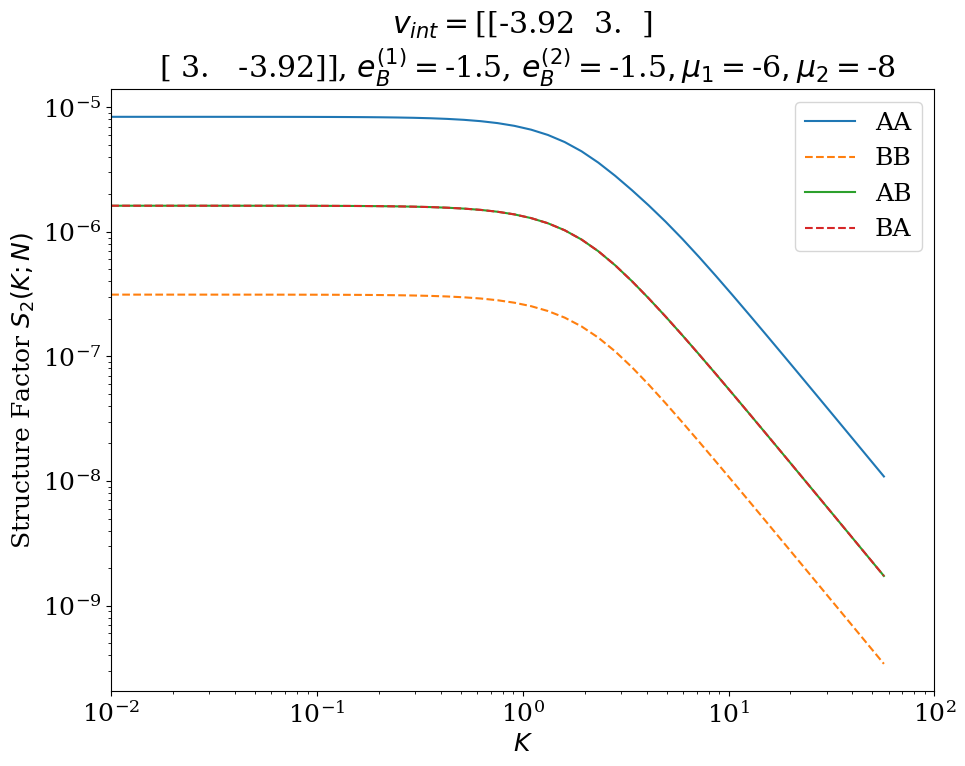

In [293]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(k_vec, S2_AA_arr, label = "AA")
plt.plot(k_vec, S2_BB_arr, label = "BB", linestyle = "--")
plt.plot(k_vec, S2_AB_arr, label = "AB")
plt.plot(k_vec, S2_BA_arr, label = "BA", linestyle="--")

# plt.plot(k_vec, s2_arr_vert_AA, label = "AA vert")
# plt.plot(k_vec, s2_arr_vert_AB, label = "AB vert")

# plt.plot(k_vec, S2_BB_arr, label = "slow", linestyle = "--")
# plt.plot(k_vec, s2AA_stat, label = "wlcstat N = " + str(N))
# plt.plot(k_vec, debye_arr, label = "debye homo N = " + str(N), linestyle = "--")

plt.xscale('log')
plt.yscale('log')

# plt.title("S2")
plt.xlabel(r'$K$')
plt.ylabel(r'Structure Factor $S_{2}(K;N)$')
plt.xlim((1e-2, 1e2))
plt.title("$v_{int} = $" + str(v_int) +  ", $e_B^{(1)} = $" + str(e_m[0]) + ", $e_B^{(2)} = $" + str(e_m[1]) + "$, \mu_1 = $" + str(mu[0]) \
          + "$, \mu_2 = $" + str(mu[1]))
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
#stability analysis:

In [ ]:
# # MULTIPLE STARTING CONDITIONS, UNBOUNDED
 
# mu_array = np.arange(-10, 10, .1)
# # mu_array = np.arange(-8, -3, 1)
# mul = len(mu_array)
# ones = np.ones(n_bind * 3)
# x0_min = -4
# x0_mid = 0
# x0_max = 4

# x0_arr = np.array([ones * x0_min, ones * x0_mid, ones*x0_mid, ones * x0_max])

# mu_mid = -5.25
# # mu_mid = -9


# mu_arrs = [mu_array, mu_array[np.where(mu_array >= mu_mid)], \
#            mu_array[np.where(mu_array <= mu_mid)][::-1], mu_array[::-1]]

# mu_fail_arr_arr = np.zeros(len(x0_arr), dtype = object)
# f_bar_arr_arr = np.zeros(len(x0_arr), dtype = object)

# for j,x0 in enumerate(x0_arr):
#     mu_ar = mu_arrs[j]
# #     print(j)
# #     print("mu arr [0]: ", mu_ar[0])
# #     print("x0[0] = ", x0[0])
#     f_bar_arr = np.zeros(len(mu_ar))
#     s_bind_0sig = np.zeros(len(mu_ar))
#     s_bind_1sig = np.zeros(len(mu_ar))
#     s_bind_2sig = np.zeros(len(mu_ar)) 
#     mu_fail_arr = np.array([])
#     x00 = x0
#     for i,mu in enumerate(mu_ar):
#         s_bind, mu_fail_arr = eval_s_bind([mu], e_m, v_int, f_om, phi_c, x00, mu_fail_arr)
#         f_bar = np.sum(f_om * s_bind)
#         s_bind_0sig[i] = s_bind[0]
#         s_bind_1sig[i] = s_bind[1]
#         s_bind_2sig[i] = s_bind[2]
#         f_bar_arr[i] = f_bar
#         if s_bind[0] is not np.nan:
#             x00 = -np.log( (2/s_bind) - 1)
   
#     f_bar_arr_arr[j] = f_bar_arr
#     mu_fail_arr_arr[j] = mu_fail_arr
# #     print("xxxxxxxxxx end of one iter xxxx")